# Tutorial: Plot Galaxy Rotation Curve with SDSS-IV MaNGA data
Author: Haeun Chung (haeunchung@email.arizona.edu)

Last update: May 17, 2022

In this tutorial, we use [SDSS-IV MaNGA](https://www.sdss.org/surveys/manga/) data to measure line of sight velocity and plot rotation curve of galaxy. 
## Required packages
* NUMPY: v1.22.3
* SCIPY: v1.8.0
* MATPLOTLIB: v3.5.2
* ASTROPY: v5.0.4
* PPXF: v8.0.2



In [1]:
import sys

try:
    import ppxf
except ModuleNotFoundError:
    !{sys.executable} -m pip install ppxf
#     import ppxf
    pass

In [2]:
# import required packages
import numpy as np
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from time import process_time as clock
from time import sleep
from astropy.io import fits
import urllib.request
import os.path
from ppxf_wrap import ppxf_wrap

%matplotlib inline

---
## Download MaNGA Data & Catalog
Download MaNGA cube data and catalog from SDSS-IV DR14 Science Archieve Server (https://data.sdss.org/sas/dr14/)

* MaNGA data access <https://www.sdss.org/dr14/manga/manga-data/data-access/>
* MaNGA catalog <https://www.sdss.org/dr13/manga/manga-data/catalogs/>
    * datamodel: <https://data.sdss.org/datamodel/files/MANGA_SPECTRO_REDUX/DRPVER/drpall.html>
    
We use logarithmically-binned cube data (LOGCUBE)

(-0.5, 561.5, 561.5, -0.5)

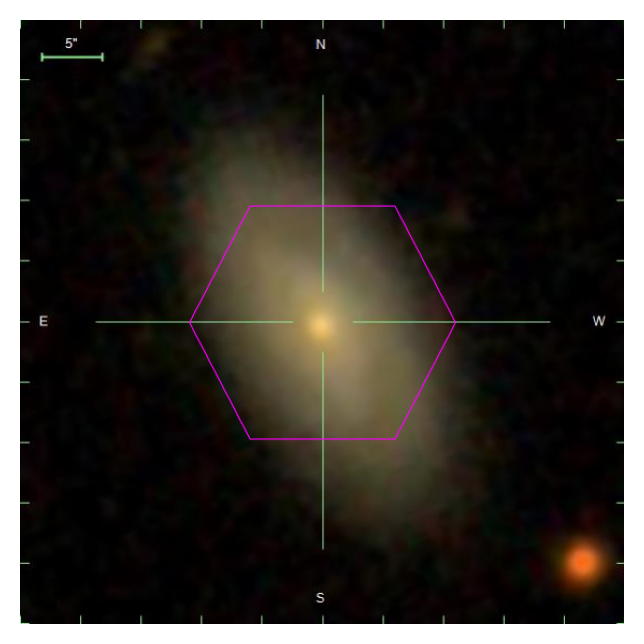

In [3]:
#if certificate error occurs, repeat this cell after several seconds of break

# plateifu of galaxy to download data
plateifu='8329-6103' # Spiral Galaxy
# plateifu='8137-6103' # Elliptical Galaxy


plate, ifuname=plateifu.split('-')
cdir='./'  #current directory

# MaNGA cube file
cube_file='manga-'+plateifu+'-LOGCUBE.fits.gz'   # file to de downloaded
sleeptime=4 #intentional gap between downloads

# download MaNGA cube file if not exist.
if not os.path.isfile(cdir+cube_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+cube_file+" from SDSS server. This may take several minutes.")
    down_url=sas_url+plate+'/stack/'+cube_file
    urllib.request.urlretrieve(down_url, cdir+cube_file)
    print('Download complete')
    sleep(sleeptime)


# MaNGA Catalog file (DR14)
drpall_file="drpall-v2_1_2.fits"

# download drpall file if not exist.
if not os.path.isfile(cdir+drpall_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+drpall_file+" from SDSS server. This may take several seconds.")
    down_url=sas_url+"drpall-v2_1_2.fits"
    urllib.request.urlretrieve(down_url, cdir+drpall_file)    
    print('Download complete')
    sleep(sleeptime)
    
image_file=plateifu+'.png'
if not os.path.isfile(cdir+image_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+image_file+" from SDSS server. This may take several seconds.")
    down_url=sas_url+plate+'/stack/images/'+ifuname+'.png'
    urllib.request.urlretrieve(sas_url+plate+'/stack/images/'+ifuname+'.png', cdir+image_file)
    print('Download complete')
    
# Show MaNGA galaxy image
fig=plt.figure(figsize=(4,4), dpi=200)
plt.imshow(mpimg.imread(cdir+image_file),aspect='equal')
plt.axis('off')

---
## Read galaxy information
In this tutorial, we need information of galaxy on
* Redshift(z)
* B/A ratio (inclination)
* Position Angle (PA)

MaNGA catalog file (drpall-v2_1_2.fits) contains above information for each galaxy.

In [4]:
drpall=fits.open(cdir+drpall_file)
tbdata=drpall[1].data
idx=np.where(tbdata['plateifu'] == plateifu)
objra=tbdata['objra'][idx][0]
objdec=tbdata['objdec'][idx][0]
nsa_z=tbdata['nsa_z'][idx][0]
nsa_elpetro_phi=tbdata['nsa_elpetro_phi'][idx][0]
nsa_elpetro_ba=tbdata['nsa_elpetro_ba'][idx][0]

print("Galaxy: ",plateifu)
print("RA, DEC:", objra, ',',objdec)
print("Redshift: ",nsa_z)
print("Position angle (degree): ", nsa_elpetro_phi)
print("b/a ratio: ", nsa_elpetro_ba)
print('More info: http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=%0.6f&dec=%0.6f&scale=0.2' % (objra, objdec))

# print(tbdata.columns.names)

Galaxy:  8329-6103
RA, DEC: 213.103435454 , 44.4608684501
Redshift:  0.0312672
Position angle (degree):  28.8381
b/a ratio:  0.641807
More info: http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=213.103435&dec=44.460868&scale=0.2


---
## Read galaxy cube data
Read and explore MaNGA Cube data.
In this tutorial, we are going to
- Plot galaxy spectrum at particular spaxel
- Plot galaxy intensity map

In [5]:
# Open and read flux, inverse variance, and mask cube.
cube = fits.open(cdir+cube_file)
flux=np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
ivar=np.transpose(cube['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))
wave = cube['WAVE'].data
specres = cube['SPECRES'].data

flux_header = cube['FLUX'].header

### Plot galaxy spectrum
* Plot galaxy spectrum at the galaxy center.
* User can plot other part by changing x_plot and y_plot

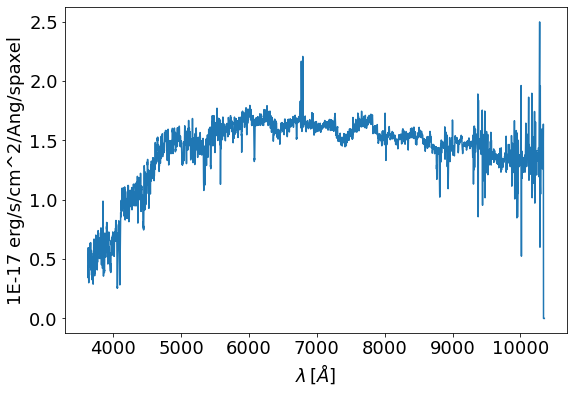

Cube 2D size:  54 by 54


In [6]:
#plot manga spectrum at the center
x_center = int(flux_header['CRPIX1']) - 1
y_center = int(flux_header['CRPIX2']) - 1

x_plot=x_center
y_plot=y_center

# User can plot other part of the galaxy
#x_plot=28
#y_plot=35

# fig=plt.figure(figsize=(9, 6))
matplotlib.rcParams['figure.figsize'] = [9, 6]
matplotlib.rc('font', family='sans-serif', size=18)
plt.plot(wave, flux[x_plot, y_plot])
plt.xlabel(r'$\lambda \, [\AA]$')
plt.ylabel(flux_header['BUNIT'])
plt.show()
# plt.rcParams['figure.figsize'] = [9, 6]

print('Cube 2D size: ', flux.shape[0], 'by', flux.shape[1])

### Plot galaxy intensity map around H$_{\alpha}$
* Integrate spectrum flux around H$_{\alpha}$ (6563 Angstrom) line. 
    * restframe 6550 to 6680 Angstrom
* Plot intensity map

Text(0, 0.5, '$\\Delta \\delta $ (arcsec)')

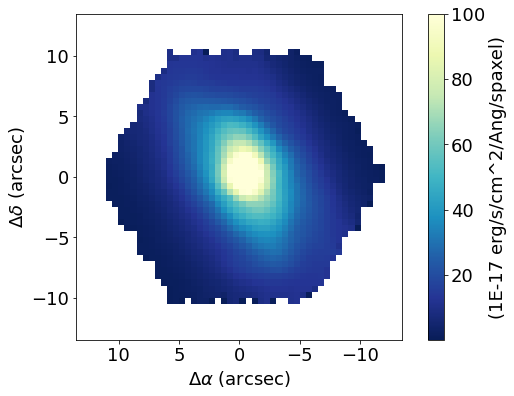

In [7]:
# process flux data 
do_not_use = (mask & 2**10) > 0
flux_m = np.ma.array(flux, mask=do_not_use)
ivar_m = np.ma.array(ivar, mask=do_not_use)

min_wave=6550
max_wave=6680
redshift = nsa_z
ind_wave = np.where((wave / (1 + redshift) > min_wave) & (wave / (1 + redshift) < max_wave))[0]
halpha = flux_m[:, :, ind_wave].sum(axis=2) # integrate flux along wavelength vector
im = halpha.T #Transpose numpy array

# Convert from array indices to arcsec relative to IFU center
dx = flux_header['CD1_1'] * 3600.  # deg to arcsec
dy = flux_header['CD2_2'] * 3600.  # deg to arcsec
x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx
y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

plt.imshow(im, extent=extent, cmap=cm.YlGnBu_r, vmin=0.1, vmax=100, origin='lower', interpolation='none')
plt.colorbar(label='('+flux_header['BUNIT']+')')
plt.xlabel(r'$\Delta \alpha $ (arcsec)')
plt.ylabel(r'$\Delta \delta $ (arcsec)')

---
## Extract galaxy kinematics
* We use Penalized Pixel-Fitting method (pPXF) developed by Michele Cappellari to extract stellar kinematics of galaxy. 
    * http://www-astro.physics.ox.ac.uk/~mxc/software/#ppxf
    * pPXF should be installed separately. Its installation command is already included at the beginning of this example. So it should have been installed already. The latest pPXF version at the time of writing this updated tutorial code is v8.0.2 (May 2022)
* pPXF fits template spectrum to the given galaxy spectrum to fit the galaxy kinematics.
* Four galaxy templates from MILES library is used in this tutorial.
    * Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/.
    * Metalicity (log(Z/Z_solar)=0), age: 1 Gyr, 2 Gyr, 8 Gyr, and 10 Gyr
        * Mun1.30Zp0.00T01.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T07.9433_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T01.9953_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T10.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits

* The warpper of pPXF is written separatly in ppxf_wrap.py.

### Measure line of sight velocity using ppxf_wrap
* To measure velocity in your own machine, **set run_vel_measure = True**. Otherwise, we use pre-saved result.
* ppxf_wrap measures velocity at each spaxel, one by one.
* Result will be saved in FITS format.

In [8]:
run_vel_measure=False
# run_vel_measure=True

oname=cdir+'manga-'+plateifu+'-LOGCUBE_MAPS.fits'

# i, j index of spaxel to show comaparison result
check_i=27
check_j=27

if run_vel_measure:
    redshift=nsa_z
    ppxf_obj=ppxf_wrap(redshift, wave, specres)
    nx, ny, _ = flux.shape
    resarr=np.zeros((nx,ny))
    flagarr=np.zeros((nx,ny),dtype=np.int16) #define flag array
    t = clock()
    check_flag=False
    wave_mask = (wave > 3700) & (wave < 7400)
    print("%2s %2s %10s %10s %5s %4s" % ('i', 'j', 'Velocity', 'Dispersion', 'Chi2', 't'))
    for j in range(nx):
        for i in range(ny):
            t = clock()
            mm_mask=((mask[j,i] & 2**10) == 0)
            if ((np.median(flux_m[i,j]) > 0) and (np.sum(mm_mask[wave_mask])>10)):
#             if np.median(flux_m[i,j]) > 0:
#                 print(i,j)
#                 ppxf_obj.flux=flux_m[i,j]
#                 ppxf_obj.ivar=ivar_m[i,j]
                ppxf_obj.flux=flux[i,j]
                ppxf_obj.ivar=ivar[i,j]
                ppxf_obj.mask=mm_mask
                
                res=ppxf_obj.run()
                if not res:
                    continue
                resarr[i,j]=res.sol[0]
                flagarr[i,j]=1
                if i == check_i & j == check_j:
                    check_flag=True
                    sflux=ppxf_obj.flux
                    sbestfit=res.bestfit
                print("%02d %02d %10.3f %10.3f %5.2f %4.1f" % (i, j, res.sol[0], res.sol[1], res.chi2, clock()-t))

    if check_flag:
        plt.plot(ppxf_obj.lam_gal, sflux[ppxf_obj.wave_mask], 'b-')
        plt.plot(ppxf_obj.lam_gal, sbestfit, 'r-')
        plt.xlabel('$\lambda \, [\AA]$')
        plt.ylabel(flux_header['BUNIT'])

    print('Save velocity measurement data in to FITS file: ', oname)
    hdu = fits.PrimaryHDU()
    hdu.writeto(oname, overwrite=True)

    fits.append(oname, resarr)
    fits.append(oname, flagarr.astype(np.int16))

    append_file=fits.open(oname, mode='update')

    hdr=append_file[1].header
    hdr.set('EXTNAME','STELLAR_VEL')
    hdr=append_file[2].header
    hdr['EXTNAME']='FLAG'

    append_file.close()

In [9]:
# noise

In [10]:
# # ((np.median(flux_m[i,j]) > 0) & (np.sum(mm_mask)>10))
# print(len(ppxf_obj.lam_gal), len(sflux))
# # len(ppxf_obj.flux[ppxf_obj.goodpixels])
# len(ppxf_obj.flux[ppxf_obj.wave_mask])
# # len(ppxf_obj.wave_mask)
# len(sbestfit)


---
## Read and plot 2D velocity map
* Use pre-saved file when user skipped the previous part.

In [11]:
# # wave=
# wave_mask = (wave > 3700) & (wave < 7400)
# lam_gal = wave[wave_mask]
# specres2=specres[wave_mask]

# meps=np.finfo('float64').eps
# noise=((ivar[0,0]**(-0.5))[wave_mask])
# noise[(noise <= 0) | ~np.isfinite(noise)]=meps
# # print(list(noise>0))
# # print(list(np.isfinite(noise)))
# # print(list(mm_mask))
# print(list(mask[j,i]))

In [12]:
# # print(list(noise))
# np.all((noise > 0) & np.isfinite(noise))

In [13]:
# # np.isfinite(flux[15,6][wave_mask])
# tnoise=((ivar[15,6]**(-0.5))[wave_mask])
# tflux=(flux[15,6])[wave_mask]
# use_mask=(mask[15,6][wave_mask] & 2**10) ==0
# # ((mask[j,i] & 2**10) == 0)
# # goodpixels
# # aa=use_mask & (noise > 0) & (np.isfinite(tnoise)) & (np.isfinite(tflux)) 
# aa=(use_mask)& (tnoise > 0) & (np.isfinite(tnoise))
# # aa=use_mask > 0
# # aa=use_mask
# # aa= (tnoise > 0) & (np.isfinite(tnoise))
# print(list(aa & 1))
# # print(list(noise>0))
# # print(list(use_mask & 2**10 > 0))
# # print(list(use_mask & 2**10 ))

Text(0, 0.5, '$\\Delta \\delta $ (arcsec)')

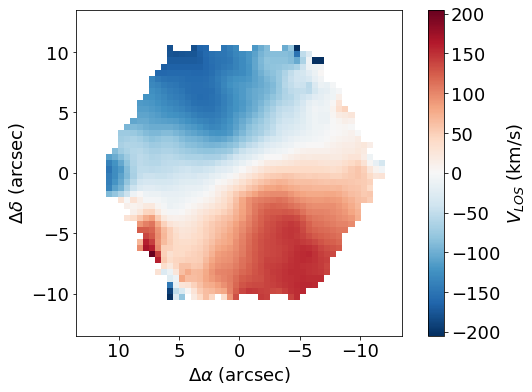

In [14]:
# read velocity map file
rfile='manga-'+plateifu+'-LOGCUBE_MAPS.fits'
if not os.path.isfile(cdir+rfile): # use pre-saved file if above one not exist.
    rfile='manga-'+plateifu+'-LOGCUBE_MAPS_SAVED.fits'
    
cube = fits.open(cdir+rfile)
velmap=cube['STELLAR_VEL'].data
nx, ny=velmap.shape

# Plot 2D map
# Calculate velocity statistics (median and standard deviation) to re-scale map values for plot)
pvelmap=velmap.T
zero_idx=(pvelmap == 0)
pvelmap[zero_idx]=np.nan
finite_idx=np.isfinite(pvelmap)
medv, stdv, sigv=(np.median(pvelmap[finite_idx]), np.std(pvelmap[finite_idx]), 2)
pvelmap=pvelmap-medv

cmap= matplotlib.cm.RdBu_r.copy()
cmap.set_bad(color='white')
plt.imshow(pvelmap, extent=extent, cmap=cmap, vmin=(-stdv*sigv), vmax=stdv*sigv, origin='lower', interpolation='none')
plt.colorbar(label='$V_{LOS}$ (km/s)')
plt.xlabel(r'$\Delta \alpha $ (arcsec)')
plt.ylabel(r'$\Delta \delta $ (arcsec)')

---
## Plot rotation curve
<img src="./gal_rot.png" alt="Drawing" style="width: 800px;"/>

* To plot rotation curve, $V(r)$, we need to perform coordinate transform of line of sight 2D velocity map into galactic coordinate system.
* A relation between $V_{LOS}$ and $V(r)$ is given as above.
* We will use known value of $V_{SYS}$, inclination angle $i$, and position angle $\phi_{0}$. All we need to do is calculating $r$ and $cos(\phi-\phi_{0})$
* How to calculate $r$ and $cos(\phi-\phi_{0})$ from $r'$ and $cos(\phi'-\phi'_{0})$ ?
    * $r\,cos(\phi-\phi_{0})=r' cos(\phi'-\phi'_{0})$ and $\phi_{0}=\phi'_{0}$
    * From tangent half-angle formula: $tan(\phi'/2)=y'/(x'+r')$
    * $tan(\phi-\phi_{0})=tan(\phi'-\phi_{0})\,cos\,i$
    * here $\phi_{0}=nsa\_elpetro\_phi+\pi/2$

(-12.497414747067209, 12.907974718380803)

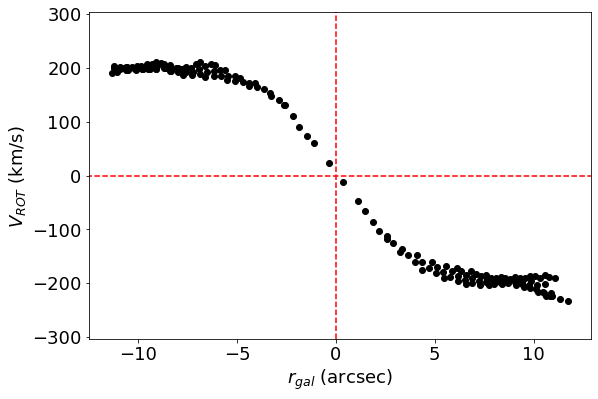

In [15]:
incl, phi0, cent_x, cent_y = np.arccos(nsa_elpetro_ba), (nsa_elpetro_phi+90)/180*pi, 0, 0

# best fitting parameters from rotation model fitting (8329-6103)
# incl, phi0, cent_x, cent_y = 1.0487251 , 0.49254251+pi/2, 0.46911521, 0.45171812

# best fitting parameters from rotation model fitting (8137-6103)
# incl, phi0, cent_x, cent_y = 0.81853998, 0.036205037+pi/2, 0.18230028, 0.32383320

aidx=np.arange(nx*ny)
ix=aidx % nx
iy=aidx // ny

x_obs=(ix-(nx/2-0.5))*0.5 # one pixel size correspond to 0.5 arcsec
y_obs=(iy-(ny/2-0.5))*0.5
r_obs=((x_obs-cent_x)**2+(y_obs-cent_y)**2)**0.5

tan_half_phi_obs=((y_obs-cent_y)/(x_obs-cent_x+r_obs))

phi_obs=2*np.arctan(tan_half_phi_obs)
tan_phi_gal=np.tan(phi_obs-phi0)/np.cos(incl)  # here phi_gal means phi_gal - PA_gal
cos_sign=np.sign(np.cos(phi_obs-phi0))
cos_phi_gal=1/((1+tan_phi_gal**2)**0.5)*cos_sign

# calculate r_gal and v_rot
r_gal=r_obs*np.cos(phi_obs-phi0)/cos_phi_gal
v_rot=pvelmap.flatten()/cos_phi_gal/np.sin(incl)

# plot points only within +/- 20 degree from major axis 
# multiply cos_sign to plot redshift/blueshifted side separately.
pr_gal=r_gal*cos_sign  
pv_rot=v_rot*cos_sign
max_angle=20
major_idx=np.flatnonzero(np.abs((phi_obs-phi0)/pi*180 % 180 ) < max_angle)
pr_gal=pr_gal[major_idx]
pv_rot=pv_rot[major_idx]

ymax=np.max(np.abs(pv_rot[np.isfinite(pv_rot)]))
xmax=np.max(np.abs(pr_gal[np.isfinite(pr_gal)]))
ymul=1.3

plt.plot(pr_gal, pv_rot, 'ko')
xlim=plt.xlim()
plt.plot([-xmax, xmax], [0,0], 'r--')
plt.plot([0,0], [-ymax*ymul,ymax*ymul], 'r--')

plt.xlabel('$r_{gal}$ (arcsec)')
plt.ylabel('$V_{ROT}$ (km/s) ')
plt.ylim([-ymax*ymul,ymax*ymul])
plt.xlim(xlim)